# PART A

In [178]:
import numpy as np
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet import preprocess_input

In [179]:
file_path = r'C:\Users\Dell\OneDrive\images.npy'
# Use NumPy to load the data with allow_pickle=True
images_data = np.load(file_path, allow_pickle=True)

In [180]:
import os

file_path = r'C:\Users\Dell\OneDrive\images.npy'

if os.path.exists(file_path):
    images_data = np.load(file_path, allow_pickle = True)
    print("File successfully loaded.")
else:
    print("File does not exist at the specified path.")

File successfully loaded.


In [181]:
data.shape

(409, 2)

### Split the data into Features(X) & labels(Y). Unify shape of all the images.

In [182]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]),IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for index in range(data.shape[0]):
  img = data[index][0]
  img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
  
  try:
    img = img[:,:,:3]
  except:
    print(f"Exception {index} Grayscale image with shape {img.shape}")
    
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    continue
  X[index] = preprocess_input(np.array(img, dtype=np.float32))

  for i in data[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
    x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
    y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)

    masks[index][y1:y2, x1:x2] = 1
print(f"### Shape of X is '{X.shape}' and the shape of mask is '{masks.shape}' ")

Exception 272 Grayscale image with shape (224, 224)
### Shape of X is '(409, 224, 224, 3)' and the shape of mask is '(409, 224, 224)' 


### Split the data into train and test[400:9].

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size=9)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2)

### Select random image from the train data and display original image and masked image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


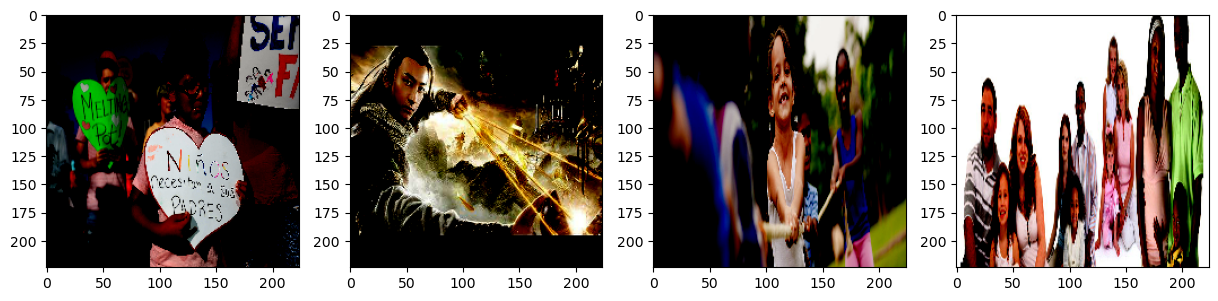

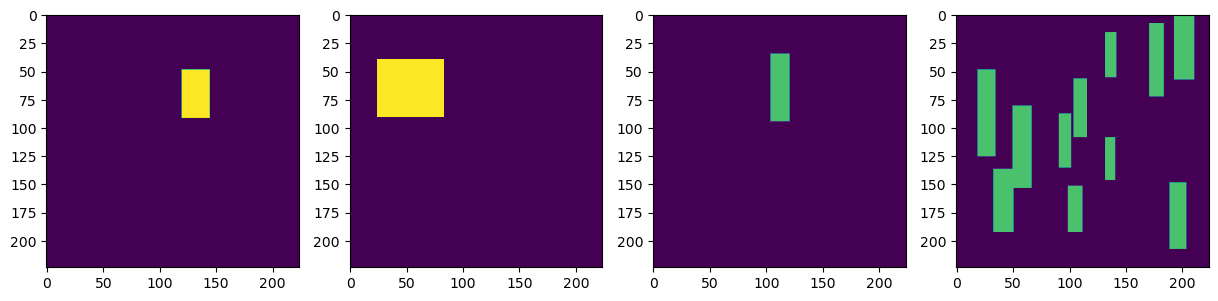

In [184]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(X_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(X_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(X_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(X_train[30])
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(y_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(y_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(y_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(y_train[30])
imgplot.set_clim(0.0, 1.4)

### Design a face mask detection model.

In [185]:
IMAGE_SIZE = 224
EPOCHS = 30
BATCH = 8
LR = 1e-4

In [186]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [102]:
model = model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 16)         432       ['input_image[0][0]']         
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 16)         64        ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 16)         0         ['bn_Conv1[0][0]']      

### Design your own Dice Coefficient and Loss function

In [103]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

### Train and tune the model as required.

In [104]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [105]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)]

In [106]:
train_steps = len(X_train)//BATCH
valid_steps = len(X_val)//BATCH

if len(X_train) % BATCH != 0:
    train_steps += 1
if len(X_val) % BATCH != 0:
    valid_steps += 1

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, steps_per_epoch=train_steps, validation_steps=valid_steps, callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 419s 7s/step - loss: 0.7048 - dice_coef: 0.2952 - recall_1: 0.6931 - precision_1: 0.2535 - val_loss: 0.6191 - val_dice_coef: 0.3809 - val_recall_1: 0.9861 - val_precision_1: 0.2274 - lr: 1.0000e-04
Epoch 2/30
50/50 [==============================] - 359s 7s/step - loss: 0.5459 - dice_coef: 0.4541 - recall_1: 0.8692 - precision_1: 0.4458 - val_loss: 0.5893 - val_dice_coef: 0.4107 - val_recall_1: 0.9811 - val_precision_1: 0.2806 - lr: 1.0000e-04
Epoch 3/30
50/50 [==============================] - 334s 7s/step - loss: 0.4822 - dice_coef: 0.5178 - recall_1: 0.8640 - precision_1: 0.5318 - val_loss: 0.4978 - val_dice_coef: 0.5022 - val_recall_1: 0.9440 - val_precision_1: 0.4483 - lr: 1.0000e-04
Epoch 4/30
50/50 [==============================] - 352s 7s/step - loss: 0.4557 - dice_coef: 0.5443 - recall_1: 0.8577 - precision_1: 0.5683 - val_loss: 0.4616 - val_dice_coef: 0.5384 - val_recall_1: 0.9142 - val_precision_1: 0.5439 - lr: 1.0000e-04


In [107]:
test_steps = (len(X_test)//BATCH)
if len(X_test) % BATCH != 0:
    test_steps += 1

model.evaluate(X_test, y_test, steps=test_steps)

1/1 [==============================] - 13s 13s/step - loss: 0.2449 - dice_coef: 0.7551 - recall_1: 0.9016 - precision_1: 0.7452


[0.24490314722061157,
 0.7550968527793884,
 0.9015764594078064,
 0.7452203631401062]

In [187]:
index_to_visualize = 3

if 0 <= index_to_visualize < len(X_test):

    test_image = X_test[index_to_visualize]
    true_mask = y_test[index_to_visualize]

    test_image_flat = test_image.flatten()

    test_image_flat = cv2.resize(test_image_flat, (224, 224))
    test_image_flat = preprocess_input(np.array(test_image_flat, dtype=np.float32))

    predicted_mask = model.predict(np.expand_dims(test_image_flat, axis=0))[0]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title("Test Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()
else:
    print(f"Invalid index: {index_to_visualize}. The index is out of range.")

Invalid index: 3. The index is out of range.


# PART B

In [188]:
import cv2
import os
import pandas as pd

In [189]:
# Load the pre-trained face detection model
face_cascade = cv2.CascadeClassifier('C:/Users/Dell/Downloads/haarcascade_frontalface_default.xml')

In [190]:
# Define the folder containing the training images
folder_path = 'C:/Users/Dell/OneDrive/training_images'

In [191]:
# Initialize an empty list to store face metadata
face_data = []

In [192]:
# Iterate through all the image files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Read the image
        image_path = os.path.join(folder_path, filename)
        img = cv2.imread(image_path)

In [193]:
# Convert the image to grayscale (required for face detection)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [194]:
# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        

In [195]:
# Extract metadata for each detected face
for (x, y, w, h) in faces:
    face_metadata = {'Image Filename': filename, 'Face X': x, 'Face Y': y, 'Face Width': w, 'Face Height': h}
    face_data.append(face_metadata)

In [196]:
# Create a DataFrame from the list of face metadata
df = pd.DataFrame(face_data)

In [197]:
# Save the DataFrame to a CSV file
df.to_csv('face_metadata.csv', index=False)

# PART C

In [116]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt, random
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity
from keras.models import Model
from keras.layers import Input, Flatten, Dense
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import to_categorical
from zipfile import ZipFile
random_state = 2020
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

In [117]:
with ZipFile('PINS.zip', 'r') as zip:
      zip.extractall()

In [118]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        self.base = base
        self.name = name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata, exts = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

In [119]:
def load_image(path):
    try:
        img = cv2.imread(path, 1)
        if img is not None:
            return img[...,::-1]  # Reverse color channels
        else:
            print(f"Warning: Unable to load image from path: {path}")
            return None
    except Exception as e:
        print(f"Error loading image: {str(e)}")
        return None

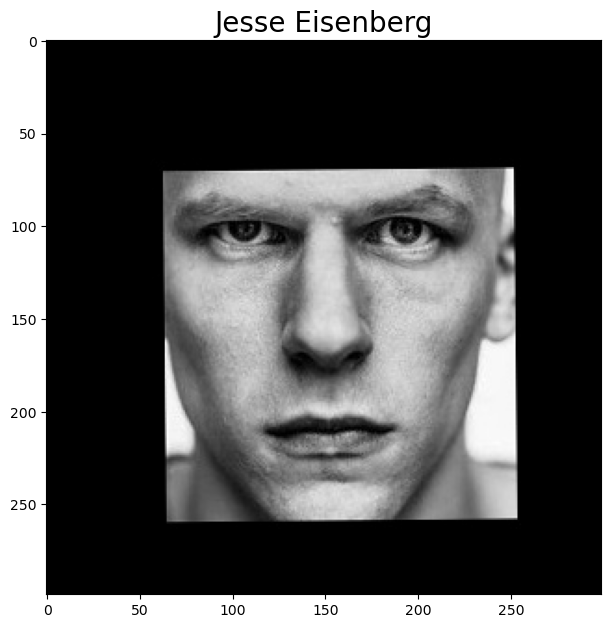

In [120]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

In [121]:
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides =(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [122]:
model = vgg_face()
model.load_weights('vgg_face_weights (1).h5')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_13 (ZeroPad  (None, 226, 226, 3)       0         
 ding2D)                                                         
                                                                 
 conv2d_34 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_14 (ZeroPad  (None, 226, 226, 64)      0         
 ding2D)                                                         
                                                                 
 conv2d_35 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                      

In [123]:
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)

In [47]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0, 1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 3s 3s/step
(2622,)


In [48]:
embeddings = []
embeddings = np.zeros((len(metadata), 2622))

for i in tqdm(range(len(metadata))):
    try:
        meta = metadata[i]
        image = load_image(meta.image_path())
        image = (image / 255.).astype(np.float32)
        image = cv2.resize(image, (224, 224))
        embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis=0))[0]
    except:
        embeddings[i] = np.zeros(2622)

  0%|          | 0/10770 [00:00<?, ?it/s]

1/1 [==============================] - 1s 547ms/step


### Build distance metrics for identifying the distance between two similar and dissimilar images

In [124]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

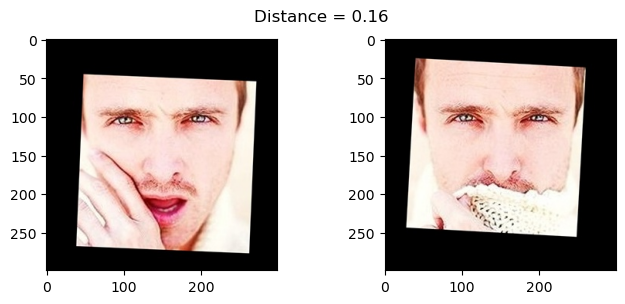

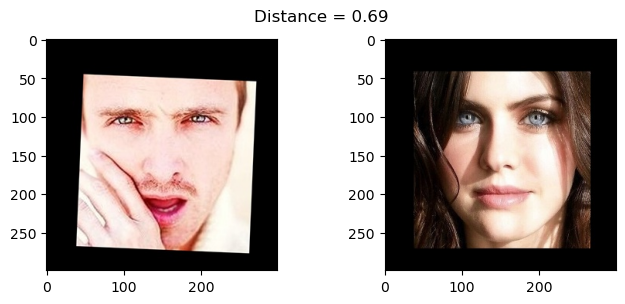

In [125]:
def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))
show_pair(2, 3)
show_pair(2, 180)

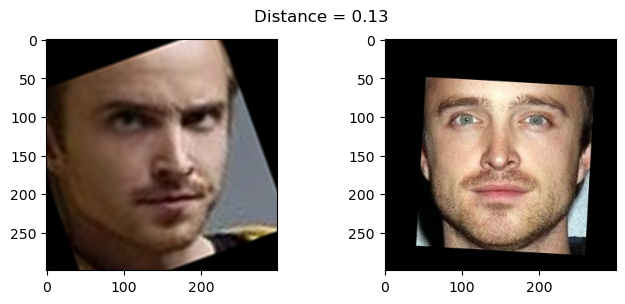

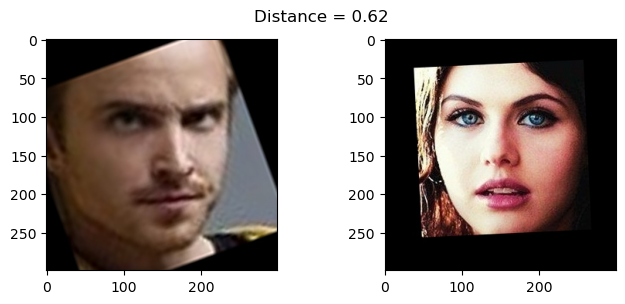

In [126]:
show_pair(30, 31)
show_pair(30, 100)

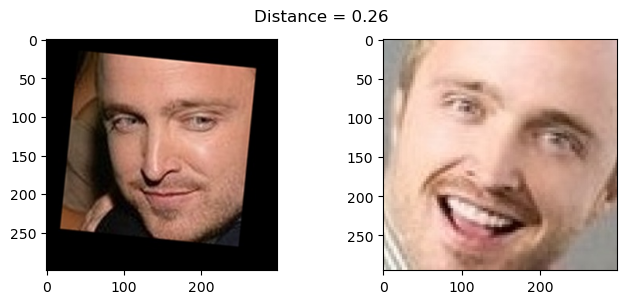

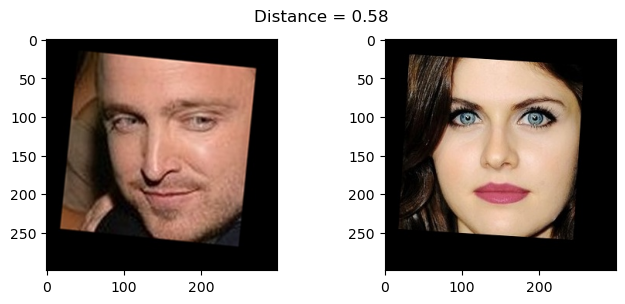

In [127]:
show_pair(70, 72)
show_pair(70, 115)

In [128]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

In [129]:
# Encode labels
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

In [130]:
# Standarize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [131]:
# Covariance matrix
cov_matrix = np.cov(X_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.58416795  18.94867841  22.94242516 ...  99.99999983  99.99999999
 100.        ]


In [132]:
# Get index where cumulative variance explained is > threshold
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres}: {str(index)}')

Index of element just greater than 95: 346


In [133]:
# Reducing the dimensions
pca = PCA(n_components = 128, random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 128)

(1197, 128)

In [134]:
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = random_state)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.976


In [135]:
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.952


In [136]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))


Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       0.91      1.00      0.95        10
            Alvaro Morte       1.00      1.00      1.00        14
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      1.00      1.00         7
          Amaury Nolasco       1.00      0.89      0.94         9
        Amber Heard Face       1.00      0.86      0.92         7
               Anna Gunn       1.00      1.00      1.00        14
           Anne Hathaway       1.00      1.00      1.00        14
     Barbara Palvin Face       0.90      1.00      0.95         9
      Bellamy Blake Face       0.93      0.93      0.93        14
    Benedict Cumberbatch       0.92      0.92      0.92        12
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       0.90      0.90      

In [143]:
def sample_img_plot(sample_idx):
  # Load image for sample_idx from test data
  sample_img = load_image(metadata[test_idx][sample_idx].image_path())
  # Get actual name
  actual_name = metadata[test_idx][sample_idx].name.split('_')[-1].title().strip()
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

1/1 [==============================] - 1s 1s/step


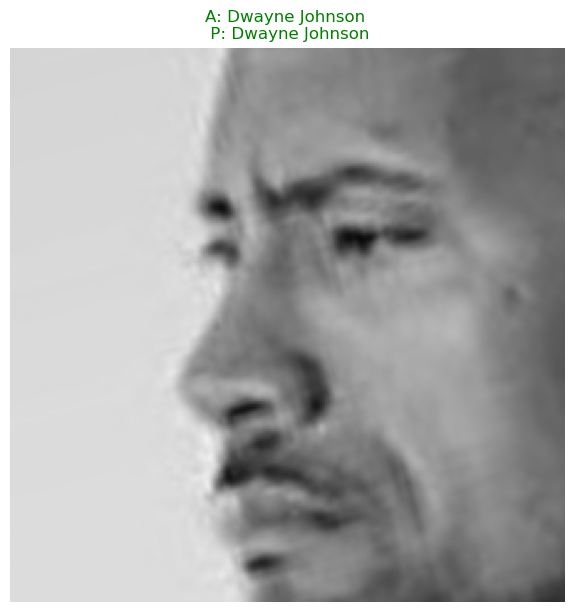

In [175]:
sample_img, actual_name, pred_name = sample_img_plot(390)
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

1/1 [==============================] - 1s 1s/step


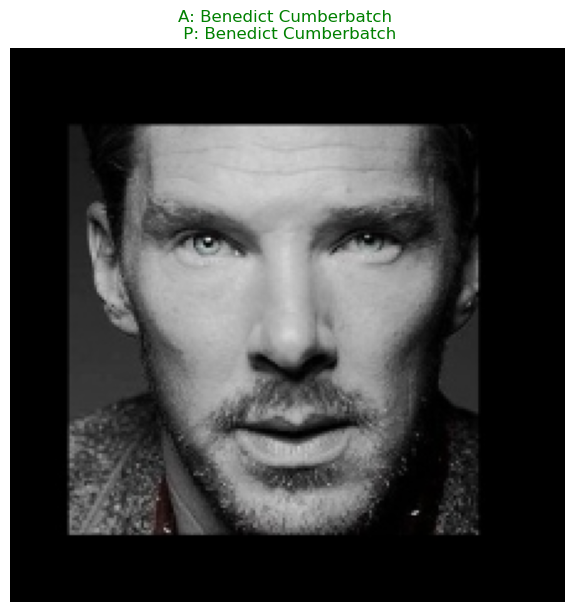

In [177]:
sample_img, actual_name, pred_name = sample_img_plot(154)
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

1/1 [==============================] - 1s 1s/step


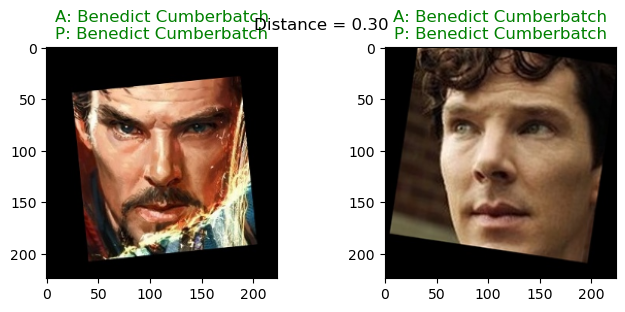

In [170]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    
    # Get the sample images and embeddings
    sample_img1, actual_name1, pred_name1 = sample_img_plot(idx1)
    sample_img2, actual_name2, pred_name2 = sample_img_plot(idx2)
    
    # Calculate the distance between embeddings
    dist = distance(vgg_face_descriptor.predict(np.expand_dims(sample_img1, axis=0))[0],
                    vgg_face_descriptor.predict(np.expand_dims(sample_img2, axis=0))[0])
    
    plt.suptitle(f'Distance = {dist:.2f}')
    
    plt.subplot(121)
    plt.imshow(sample_img1)
    plt.title(f"A: {actual_name1}\nP: {pred_name1}", color='green' if actual_name1 == pred_name1 else 'red')
    
    plt.subplot(122)
    plt.imshow(sample_img2)
    plt.title(f"A: {actual_name2}\nP: {pred_name2}", color='green' if actual_name2 == pred_name2 else 'red')

# Example usage
show_pair(150, 151)

1/1 [==============================] - 1s 1s/step


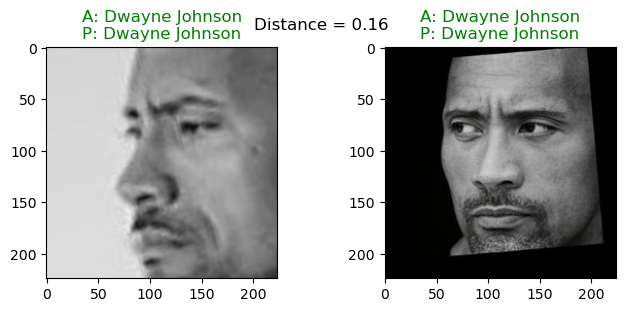

In [174]:
show_pair(390, 391)